In [1]:
!nvidia-smi
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

Mon Oct 21 06:35:46 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1660 ...    Off |   00000000:0A:00.0 Off |                  N/A |
|  0%   36C    P8             11W /  140W |      15MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/rapids/notebooks


In [3]:
%cd {HOME}
!git clone https://github.com/WongKinYiu/yolov7
%cd {HOME}/yolov7
!pip install -r requirements.txt
import sys
sys.path.append(f"{HOME}/yolov7")

/rapids/notebooks
Cloning into 'yolov7'...
remote: Enumerating objects: 1197, done.
remote: Total 1197 (delta 0), reused 0 (delta 0), pack-reused 1197 (from 1)
Receiving objects: 100% (1197/1197), 74.23 MiB | 11.36 MiB/s, done.
Resolving deltas: 100% (520/520), done.
/rapids/notebooks/yolov7
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 30.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 36.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.21.12
    Uninstalling protobuf-4.21.12:
      Successfully uninstalled protobuf-4.21.12
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account a

In [15]:
%cd {HOME}
!mkdir input
%cd {HOME}/input
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=18GqZ3dk6xWO3CPzNbVoO-EwMkStcpM-M' -O video.mp4
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=15mS0wSPrMA48X5-fwhDh4N1CPXvWNGAz' -O bird_detection.pt
%cd {HOME}/yolov7
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6-pose.pt --quiet

/home/josephlu/baddie-watch
mkdir: cannot create directory ‘input’: File exists
/home/josephlu/baddie-watch/input
--2024-10-10 17:10:56--  https://docs.google.com/uc?export=download&id=18GqZ3dk6xWO3CPzNbVoO-EwMkStcpM-M
Resolving docs.google.com (docs.google.com)... 142.251.32.78, 2607:f8b0:400b:807::200e
Connecting to docs.google.com (docs.google.com)|142.251.32.78|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=18GqZ3dk6xWO3CPzNbVoO-EwMkStcpM-M&export=download [following]
--2024-10-10 17:10:56--  https://drive.usercontent.google.com/download?id=18GqZ3dk6xWO3CPzNbVoO-EwMkStcpM-M&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.41.33, 2607:f8b0:400b:803::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.41.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1028748 (1005K) [video/mp4]
Saving to: 

In [16]:
SOURCE_VIDEO_PATH = f"{HOME}/input/video.mp4"
TARGET_VIDEO_PATH = f"{HOME}/output/video.mp4"
BIRD_DETECTION_MODEL_WEIGHTS_PATH = f"{HOME}/input/bird_detection.pt"
POSE_MODEL_WEIGHTS_PATH = f"{HOME}/yolov7/yolov7-w6-pose.pt"

In [17]:
from typing import Generator

import matplotlib.pyplot as plt
import numpy as np

import cv2

%matplotlib inline

def generate_frames(video_file: str) -> Generator[np.ndarray, None, None]:
    video = cv2.VideoCapture(video_file)
    if not video.isOpened():
        raise ValueError("Cannot open video file")

    while video.isOpened():
        success, frame = video.read()

        if not success:
            break

        yield frame

    video.release()


def plot_image(image: np.ndarray, size: int = 12) -> None:
    plt.figure(figsize=(size, size))
    plt.axis('off')
    plt.imshow(image[...,::-1])
    plt.show()

In [18]:
from typing import Optional, Tuple
from dataclasses import dataclass


@dataclass(frozen=True)
class Point:
    x: float
    y: float

    @property
    def int_xy_tuple(self) -> Tuple[int, int]:
        return int(self.x), int(self.y)


@dataclass(frozen=True)
class Rect:
    x: float
    y: float
    width: float
    height: float

    @property
    def top_left(self) -> Point:
        return Point(x=self.x, y=self.y)

    @property
    def bottom_right(self) -> Point:
        return Point(x=self.x + self.width, y=self.y + self.height)

    @property
    def bottom_center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y + self.height)

@dataclass
class Detection:
    rect: Rect
    class_id: int
    confidence: float
    tracker_id: Optional[int] = None


@dataclass(frozen=True)
class Color:
    r: int
    g: int
    b: int

    @property
    def bgr_tuple(self) -> Tuple[int, int, int]:
        return self.b, self.g, self.r


In [19]:
import cv2

import numpy as np

def draw_rect(image: np.ndarray, rect: Rect, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.rectangle(image, rect.top_left.int_xy_tuple, rect.bottom_right.int_xy_tuple, color.bgr_tuple, thickness)
    return image

In [20]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [21]:
weights = torch.load(POSE_MODEL_WEIGHTS_PATH, map_location=device, weights_only=False)
pose_model = weights["model"]
_ = pose_model.float().eval()

if torch.cuda.is_available():
    pose_model.half().to(device)
    
import inference
from ultralytics import YOLO
import os
from dotenv import load_dotenv

load_dotenv()


bird_model = YOLO(BIRD_DETECTION_MODEL_WEIGHTS_PATH)
ROBOFLOW_API_KEY=os.getenv('ROBOFLOW_API_KEY')
court_detection_model = inference.get_model("badminton-court-detection-cfgah/3",api_key=ROBOFLOW_API_KEY)
# court_detection_model = inference.get_model("badminton-court-detection-cfgah/3")

[10/10/24 17:11:47] WARNING  Your inference package version 0.21.0 is out of date! Please upgrade to ]8;id=129531;file:///home/josephlu/miniconda3/envs/rapids-24.08/lib/python3.10/site-packages/inference/core/__init__.py\__init__.py]8;;\:]8;id=831899;file:///home/josephlu/miniconda3/envs/rapids-24.08/lib/python3.10/site-packages/inference/core/__init__.py#41\41]8;;\
                             version 0.22.2 of inference for the latest features and bug fixes by                  
                             running `pip install --upgrade inference`.                                            

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
2024-10-10 17:11:50.463046026 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:640 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements to ensure all dependencies are met.


In [22]:
DETECTION_IMAGE_SIZE = 1920
POSE_IMAGE_SIZE = 960
STRIDE = 64
CONFIDENCE_TRESHOLD = 0.25
IOU_TRESHOLD = 0.65

In [23]:
from utils.datasets import letterbox
from torchvision import transforms

import numpy as np


def detection_pre_process_frame(frame: np.ndarray, device: torch.device) -> torch.Tensor:
    img = letterbox(frame, DETECTION_IMAGE_SIZE, STRIDE, auto=True)[0]
    img = img[:, :, ::-1].transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img).to(device).float()
    img /= 255.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
    return img

def pose_pre_process_frame(frame: np.ndarray, device: torch.device) -> torch.Tensor:
    image = letterbox(frame, POSE_IMAGE_SIZE, stride=STRIDE, auto=True)[0]
    image = transforms.ToTensor()(image)
    image = torch.tensor(np.array([image.numpy()]))

    if torch.cuda.is_available():
        image = image.half().to(device)

    return image

In [13]:
from typing import Tuple

from utils.general import non_max_suppression_kpt, non_max_suppression
from utils.plots import output_to_keypoint

import numpy as np


# def clip_coords(boxes: np.ndarray, img_shape: Tuple[int, int]):
#     # Clip bounding xyxy bounding boxes to image shape (height, width)
#     boxes[:, 0] = np.clip(boxes[:, 0], 0, img_shape[1]) # x1
#     boxes[:, 1] = np.clip(boxes[:, 1], 0, img_shape[0]) # y1
#     boxes[:, 2] = np.clip(boxes[:, 2], 0, img_shape[1]) # x2
#     boxes[:, 3] = np.clip(boxes[:, 3], 0, img_shape[0]) # y2


# def detection_post_process_output(
#     output: torch.tensor,
#     confidence_trashold: float,
#     iou_trashold: float,
#     image_size: Tuple[int, int],
#     scaled_image_size: Tuple[int, int]
# ) -> np.ndarray:
#     output = non_max_suppression(
#         prediction=output,
#         conf_thres=confidence_trashold,
#         iou_thres=iou_trashold
#     )
#     coords = output[0].detach().cpu().numpy()

#     v_gain = scaled_image_size[0] / image_size[0]
#     h_gain = scaled_image_size[1] / image_size[1]

#     coords[:, 0] /= h_gain
#     coords[:, 1] /= v_gain
#     coords[:, 2] /= h_gain
#     coords[:, 3] /= v_gain

#     clip_coords(coords, image_size)
#     return coords


def post_process_pose(pose: np.ndarray, image_size: Tuple, scaled_image_size: Tuple) -> np.ndarray:
    height, width = image_size
    scaled_height, scaled_width = scaled_image_size
    vertical_factor = height / scaled_height
    horizontal_factor = width / scaled_width
    result = pose.copy()
    for i in range(17):
        result[i * 3] = horizontal_factor * result[i * 3]
        result[i * 3 + 1] = vertical_factor * result[i * 3 + 1]
    return result


def pose_post_process_output(
    output: torch.tensor,
    confidence_trashold: float,
    iou_trashold: float,
    image_size: Tuple[int, int],
    scaled_image_size: Tuple[int, int]
) -> np.ndarray:
    output = non_max_suppression_kpt(
        prediction=output,
        conf_thres=confidence_trashold,
        iou_thres=iou_trashold,
        nc=pose_model.yaml['nc'],
        nkpt=pose_model.yaml['nkpt'],
        kpt_label=True)

    with torch.no_grad():
        output = output_to_keypoint(output)

        for idx in range(output.shape[0]):
            output[idx, 7:] = post_process_pose(
                output[idx, 7:],
                image_size=image_size,
                scaled_image_size=scaled_image_size
            )

    return output

In [20]:
import matplotlib.path as mpltPath
left_foot_k_id = 15
right_foot_k_id = 16
right_shoulder_k_id = 6
right_elbow_k_id = 8
right_wrist_k_id = 10

def get_coords(pose, kid, steps):
    x_coord, y_coord = pose[steps * kid], pose[steps * kid + 1]
    return x_coord, y_coord

def get_ppl_on_side(side, detections):
    ppl = []
    polygon = [[point.x, point.y] for point in side[0].points]
    path = mpltPath.Path(polygon)
    for idx in range(detections.shape[0]):
        pose = detections[idx, 7:].T
        left_x_coord, left_y_coord = get_coords(pose, left_foot_k_id, 3)
        right_x_coord, right_y_coord = get_coords(pose, right_foot_k_id, 3)
        if path.contains_points([[left_x_coord, left_y_coord], [right_x_coord, right_y_coord]]).any():
            ppl.append(idx)
    return ppl


In [21]:
from utils.plots import plot_skeleton_kpts


# def detect_annotate(image: np.ndarray, detections: np.ndarray, color: Color, thickness: int = 2) -> np.ndarray:
#     annotated_image = image.copy()
#     for x_min, y_min, x_max, y_max, confidence, class_id in detections:
#         rect = Rect(
#             x=float(x_min),
#             y=float(y_min),
#             width=float(x_max - x_min),
#             height=float(y_max - y_min)
#         )
#         annotated_image = draw_rect(image=annotated_image, rect=rect, color=color, thickness=thickness)

#     return annotated_image



def draw_kid_black(kid, steps, pose, annotated_frame):
    x_coord,y_coord = get_coords(pose, kid, steps)
    cv2.circle(annotated_frame, (int(x_coord), int(y_coord)), 5, (0,0,0), -1)


def pose_annotate(image: np.ndarray, detections: np.ndarray, side) -> np.ndarray:
    annotated_frame = image.copy()
    ppl = get_ppl_on_side(side, detections)
    if len(ppl) == 1:
        idx = ppl[0]
        pose = detections[idx, 7:].T
        plot_skeleton_kpts(annotated_frame, pose, 3)
        # draw_kid_black(8, 3, pose, annotated_frame)
        # draw_kid_black(10, 3, pose, annotated_frame)

    return annotated_frame

In [22]:
def get_near_side(frame):
    court_sides_inference = court_detection_model.infer(frame)[0]
    return [prediction for prediction in court_sides_inference.predictions if prediction.class_name == 'near-side']

In [17]:
def process_frame_and_annotate(frame: np.ndarray) -> Tuple[np.ndarray,np.ndarray]:
    pose_pre_processed_frame = pose_pre_process_frame(frame=frame.copy(), device=device)

    image_size = frame.shape[:2]
    scaled_image_size = tuple(pose_pre_processed_frame.size())[2:]

    with torch.no_grad():
        pose_output, _ = pose_model(pose_pre_processed_frame)
        pose_output = pose_post_process_output(
            output=pose_output,
            confidence_trashold=CONFIDENCE_TRESHOLD,
            iou_trashold=IOU_TRESHOLD,
            image_size=image_size,
            scaled_image_size=scaled_image_size
        )

    near_side = get_near_side(frame)

    annotated_frame = pose_annotate(image=frame, detections=pose_output, side=near_side)

    return annotated_frame, pose_output

In [24]:
from inference import get_model
import supervision as sv

def get_frame_from_vid(frames_into_vid):
    frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH))
    frame = None
    for i in range(frames_into_vid):
        frame = next(frame_iterator)
    return frame



def get_bird_detections(frame, tracker, conf_thres, track=True):
    model = get_model(model_id="shuttlecock-cqzy3/1",api_key=ROBOFLOW_API_KEY)
    bird_output = model.infer(frame, conf=conf_thres)[0]
    detections = sv.Detections.from_inference(bird_output)
    if track:
        detections = tracker.update_with_detections(detections)
    return detections

def convert_detections_to_rects(detections):
    return [
        Rect(x=rect[0],
             y=rect[1],
             width=rect[2]-rect[0],
             height=rect[3]-rect[1])
        for rect in detections.xyxy
        ]

def draw_rects(frame, rects):
    annotated_frame = frame
    for rect in rects:
        annotated_frame = draw_rect(image=annotated_frame,
                                    rect=rect,
                                    color=Color(r=0, g=255, b=0),
                                    thickness=2)
    return annotated_frame

def annotate_near_side(frame):
    inference = court_detection_model.infer(frame)[0]
    near_side = [prediction for prediction in inference.predictions if prediction.class_name == 'near-side']
    if not near_side:
        raise Exception('no near side')
    near_side_points = np.array([[round(point.x), round(point.y)] for point in near_side[0].points])
    zones = [sv.PolygonZone(polygon=near_side_points)]
    zone_annotators = [sv.PolygonZoneAnnotator(zone=zone, color=sv.Color(255, 0, 0), thickness=4) for zone in zones]

    annotated_frame = zone_annotators[0].annotate(scene=frame, label="near-side")
    return annotated_frame

2024-10-07 09:53:57.538304953 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:640 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements to ensure all dependencies are met.


Detections(xyxy=array([[        587,         233,         601,         246]]), mask=None, confidence=array([    0.52622]), class_id=array([0]), tracker_id=array([4]), data={'class_name': array(['Shuttlecock'], dtype='<U11')})


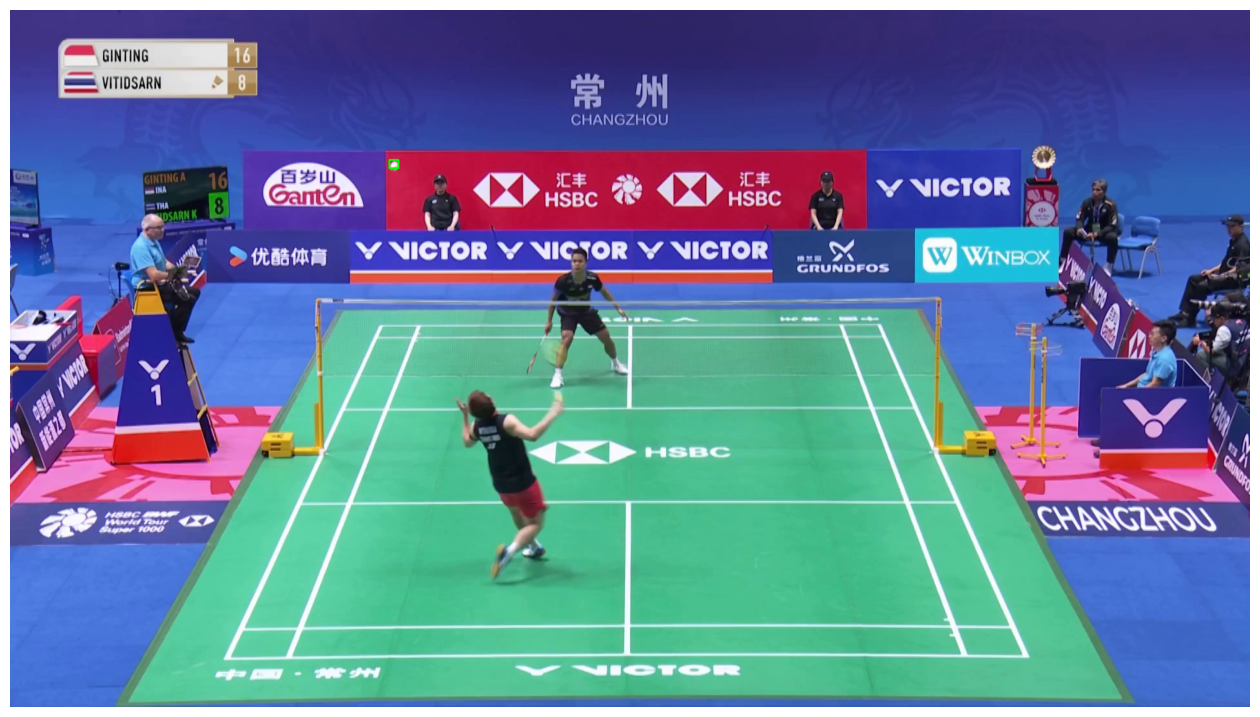

In [28]:
import supervision as sv
%matplotlib inline
tracker = sv.ByteTrack(track_activation_threshold=0.4)
annotated_frame = get_frame_from_vid(10)

detections = get_bird_detections(annotated_frame, tracker, 0.4, track=True)
print(detections)
rects = convert_detections_to_rects(detections=detections)
annotated_frame = draw_rects(annotated_frame, rects)

plot_image(annotated_frame, 16)


In [ ]:

from dataclasses import dataclass

import cv2


"""
usage example:

video_config = VideoConfig(
    fps=30,
    width=1920,
    height=1080)
video_writer = get_video_writer(
    target_video_path=TARGET_VIDEO_PATH,
    video_config=video_config)

for frame in frames:
    ...
    video_writer.write(frame)

video_writer.release()
"""


# stores information about output video file, width and height of the frame must be equal to input video
@dataclass(frozen=True)
class VideoConfig:
    fps: float
    width: int
    height: int


# create cv2.VideoWriter object that we can use to save output video
def get_video_writer(target_video_path: str, video_config: VideoConfig) -> cv2.VideoWriter:
    video_target_dir = os.path.dirname(os.path.abspath(target_video_path))
    os.makedirs(video_target_dir, exist_ok=True)
    return cv2.VideoWriter(
        target_video_path,
        fourcc=cv2.VideoWriter_fourcc(*"mp4v"),
        fps=video_config.fps,
        frameSize=(video_config.width, video_config.height),
        isColor=True
    )


def get_frame_count(path: str) -> int:
    cap = cv2.VideoCapture(path)
    return int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

## bird detection

In [24]:
import supervision as sv

source = f'{HOME}/input/rally.mp4'

tracker = sv.ByteTrack(track_activation_threshold=0.01, minimum_matching_threshold=0.00000001, lost_track_buffer=60)
bird_x = []
bird_y = []
KNN_subtractor = cv2.createBackgroundSubtractorKNN(detectShadows = True) # detectShadows=True : exclude shadow areas from the objects you detected
MOG2_subtractor = cv2.createBackgroundSubtractorMOG2(detectShadows = True) # exclude shadow areas from the objects you detected
bg_subtractor=MOG2_subtractor
bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

def callback(frame, idx):
    # foreground_mask = bg_subtractor.apply(frame)
    # ret , threshold = cv2.threshold(foreground_mask.copy(), 120, 255,cv2.THRESH_BINARY)
    # dilated = cv2.dilate(threshold,cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3)),iterations = 2)
    # masked_frame = cv2.bitwise_and(frame, frame, mask=dilated)
    detections = get_bird_detections(frame, tracker, 0.15, track=True)
    annotated_frame = bounding_box_annotator.annotate(scene=frame, detections=detections)
    if detections:
        labels = [
                    f"{class_name} {confidence:.2f}"
                    for class_name, confidence
                    in zip(detections['class_name'], detections.confidence)
                ]
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections,labels=labels)
    # print(detections)
    # rects = convert_detections_to_rects(detections=detections)
    # annotated_frame = draw_rects(frame, rects)
    # print(idx)
    return annotated_frame

print('starting')
sv.process_video(source_path=source,
                 target_path=TARGET_VIDEO_PATH,
                 callback=callback)
print('done')


# plt.plot(np.arange(len(bird_x)), bird_x, color="green")
# plt.plot(np.arange(len(bird_y)), bird_y, color="red")
# plt.show()



SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


starting


2024-10-08 16:48:08.062411088 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:640 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements to ensure all dependencies are met.
2024-10-08 16:48:08.430553994 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:640 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements to ensure all dependencies are met.
2024-10-08 16:48:08.632944854 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:640 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements to ensure all dependencies are met.
2024-10-08 16:48:08.819539926 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:640 CreateExecu

done


2024-10-08 16:49:02.840670300 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:640 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements to ensure all dependencies are met.


In [27]:
import supervision as sv
import csv

%cd {HOME}

frame_to_xy = {}
bounding_box_annotator = sv.BoundingBoxAnnotator()

with open('./rally_ball.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        frame_to_xy[int(row["Frame"])] = [int(row["X"]), int(row["Y"])]


def callback(frame, idx):
    x,y = frame_to_xy[idx]
    annotated_frame = draw_rects(frame, [Rect(x-10,y-10,20,20)])
    return annotated_frame



sv.process_video(source_path='./input/rally.mp4', target_path='./output/rally_annotated.mp4', callback=callback)

/home/josephlu/baddie-watch


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


#### Just Mask

In [101]:
import supervision as sv
tracker = sv.ByteTrack(track_activation_threshold=0.0001, minimum_matching_threshold=0.00001)
bird_x = []
bird_y = []
KNN_subtractor = cv2.createBackgroundSubtractorKNN(detectShadows = True) # detectShadows=True : exclude shadow areas from the objects you detected
MOG2_subtractor = cv2.createBackgroundSubtractorMOG2(detectShadows = True) # exclude shadow areas from the objects you detected
bg_subtractor=MOG2_subtractor

def callback(frame, idx):
    foreground_mask = bg_subtractor.apply(frame)
    ret , threshold = cv2.threshold(foreground_mask.copy(), 120, 255,cv2.THRESH_BINARY)
    #  dilation expands or thickens regions of interest in an image.
    dilated = cv2.dilate(threshold,cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3)),iterations = 2)
    masked_frame = cv2.bitwise_and(frame, frame, mask=dilated)
    # if len(detections.xyxy) == 0:
    return masked_frame

print('starting')
sv.process_video(source_path=f'{HOME}/input/input.mp4',
                 target_path=f'{HOME}/output/masked.mp4',
                 callback=callback)
print('done')


# plt.plot(np.arange(len(bird_x)), bird_x, color="green")
# plt.plot(np.arange(len(bird_y)), bird_y, color="red")
# plt.show()



starting
done


In [124]:
!pip list | grep supervision

supervision                       0.22.0
